In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

WHITE, BLACK = 127, 225

In [2]:
# read in image in greyscale
def getImg(image_path):
    return cv2.imread(image_path, 0)

def binarizeImg(im):
    ret, thresh_img = cv2.threshold(im,WHITE, BLACK,cv2.THRESH_BINARY) # Simple threshold
    thresh_img = cv2.adaptiveThreshold(thresh_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    return thresh_img

def cvtImageToPoints(binImg):
    Xs = []
    Ys = []
    data = []
    h, w = binImg.shape
    #print(h,w)
    for i in range(h):
        for j in range(w):
            if binImg[i][j] == 0:
                Xs.append(j)
                Ys.append(i)
                data.append([j,i])
    return np.asarray(data), np.asarray(Xs), np.asarray(Ys)

def getFirstComponent(image_path):
    img = getImg(image_path)
    plt.imshow(img, cmap = 'gray')
    thresh_img = binarizeImg(img)
    data, Xs, Ys = cvtImageToPoints(thresh_img)
    mean_vec = np.mean(data, axis=0)
    # Calculate the deviations from the mean
    cov_mat = (data - mean_vec).T.dot((data - mean_vec)) / (data.shape[0]-1)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    
    vec_x = [(eig_pairs[0][1][0]+eig_pairs[0][1][0])/2, (eig_pairs[0][1][1]+eig_pairs[1][1][0])/2]
    vec_y = [(eig_pairs[1][1][0]+eig_pairs[0][1][1])/2, (eig_pairs[1][1][1]+eig_pairs[1][1][1])/2]
    
    first_cpts = [vec_x[0],vec_y[0]] # more robust
    #first_cpts = [eig_pairs[0][1][0], eig_pairs[1][1][0]] # more sensitive one
    
#     fig, ax = plt.subplots()
#     plt.ylim(thresh_img.shape[0], 0)
#     ax.scatter(Xs, Ys, marker='.', color = 'black')
#     ax.quiver([thresh_img.shape[0]/2,thresh_img.shape[0]/2], [thresh_img.shape[0]/2,thresh_img.shape[0]/2], [eig_pairs[0][1][0],eig_pairs[1][1][0]] , [eig_pairs[0][1][1], eig_pairs[1][1][1]], scale=10, color=['r','g'])
#     ax.quiver([thresh_img.shape[0]/2,thresh_img.shape[0]/2], [thresh_img.shape[0]/2,thresh_img.shape[0]/2], eig_pairs[0][1], eig_pairs[1][1], scale=10, color=['b','y'])
#     ax.quiver([thresh_img.shape[0]/2,thresh_img.shape[0]/2], [thresh_img.shape[0]/2,thresh_img.shape[0]/2], vec_x, vec_y, scale=10, color=['white','gray'])

    
    return first_cpts

def isFlipped(thresh_img):
    left = thresh_img[0:thresh_img.shape[0], 0:thresh_img.shape[1]//4]
    right = thresh_img[0:thresh_img.shape[0], (thresh_img.shape[1]-thresh_img.shape[1]//4):thresh_img.shape[1]]
    return len(cvtImageToPoints(left)[0]) < len(cvtImageToPoints(right)[0])

def getAngle(vector):
    from math import atan2, pi
    rad = atan2(vector[1], vector[0])
    deg = rad/(2*pi) * 360
    #print(deg)
    return deg

# angle in degree, positive means clockwise rotation
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)
    
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH),borderMode=0, borderValue=(255,255,255))

def rotateImg(data_path):
    img = getImg(data_path)
    im = binarizeImg(img)
    first_cpts = getFirstComponent(data_path)
    #print('first', first_cpts)
    rotated = rotate_bound(img, getAngle(first_cpts))
    if isFlipped(rotated):
        first_cpts = [-1*first_cpts[0], -1*first_cpts[1]]
        rotated = rotate_bound(im, getAngle(first_cpts))
    rotated = rotate_bound(img, getAngle(first_cpts))
    return rotated

OpenCV(3.4.1) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/filter.cpp:288: error: (-215) wholeSize.width > 0 && wholeSize.height > 0 in function proceed



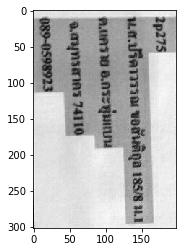

In [3]:
onlyfiles = [f for f in os.listdir('/Users/i351707/Desktop/useful_python_files/cropped_images')]
os.chdir('/Users/i351707/Desktop/useful_python_files/cropped_images/')
for file in onlyfiles:
    try:
        rotated = rotateImg(file)

        cv2.imwrite(file.split('.')[0]+'.jpg',rotated)
    except Exception as e:
        print (e)